In [39]:
using Distributions
using PyCall
using PyPlot
using DelimitedFiles
using LinearAlgebra
using Random
using SparseArrays
using StatsBase
using QuadGK
using SpecialFunctions

In [40]:
# Read in relevant model parameters
include("src_rate/param.jl");

# Initialize recurrent weights

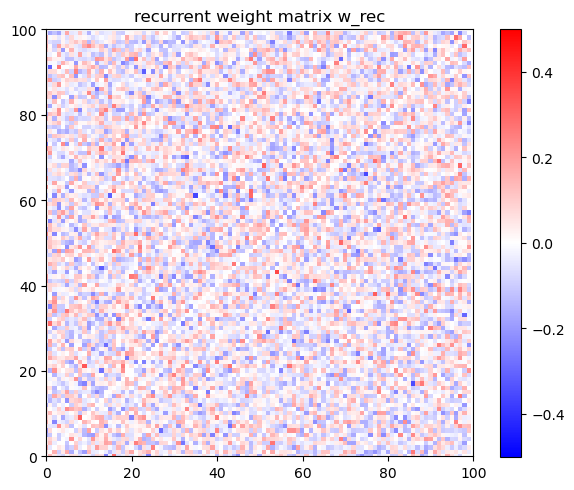

In [41]:
include("src_rate/genWeights.jl") 
w_rec = genWeights(p.Ncells,0,1)/sqrt(p.Ncells) #divide by sqrt(p.Ncells)?
w_rec_init = copy(w_rec) # save a copy of the initialized recurrent weights

# Plot recurrent weight matrix
fig, ax = subplots(figsize=(6, 6))

# Custom normalization centered at 0
norm = matplotlib.colors.CenteredNorm(vcenter=0, halfrange=0.5)
cax = ax.imshow(w_rec, cmap="bwr", norm=norm)
colorbar(cax, shrink=0.75)

xlim(0,p.Ncells)
ylim(0,p.Ncells)
title("recurrent weight matrix w_rec")

# Show plot
tight_layout()
show()

# Generate target rates

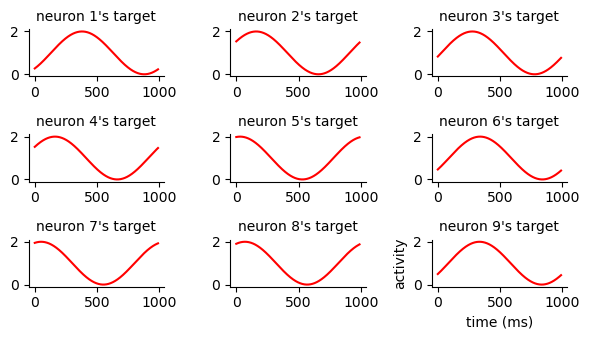

In [42]:
include("src_rate/generate_target_rates.jl") 
r_targ = generate_target_rates(p)

# show target activity patterns
figure(figsize=(6,3.5))
for ci = 1:9
    ax = subplot(3,3,ci)
    plot(r_targ[Int((p.stim_off+1)/p.dt):end,ci], c="r")
    title("neuron $(ci)'s target", fontsize=10)
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
end
xlabel("time (ms)")
ylabel("activity")
tight_layout()
#savefig("figure/target.pdf")
PyPlot.display_figs()

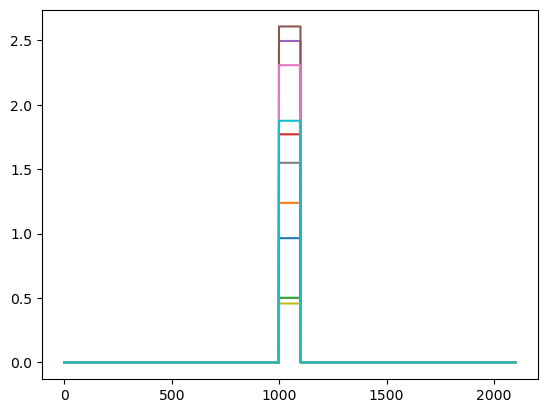

10-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x35103a9c0>
 PyObject <matplotlib.lines.Line2D object at 0x35103ae10>
 PyObject <matplotlib.lines.Line2D object at 0x35103ac60>
 PyObject <matplotlib.lines.Line2D object at 0x351038650>
 PyObject <matplotlib.lines.Line2D object at 0x350ef8560>
 PyObject <matplotlib.lines.Line2D object at 0x3510e41d0>
 PyObject <matplotlib.lines.Line2D object at 0x3510e4950>
 PyObject <matplotlib.lines.Line2D object at 0x3510e4a40>
 PyObject <matplotlib.lines.Line2D object at 0x3510e4b30>
 PyObject <matplotlib.lines.Line2D object at 0x3510e4c20>

In [43]:
# define stimulus to trigger response in cells
scalar = 2
stim = 2*(2*rand(Int(p.Ncells))); #generate stimulus magnitudes for each cell
#stim = scalar * LogNormal(0, 1)

I_ext = zeros(p.Nsteps,p.Ncells) #initialize external input 
for ti = 1:p.Nsteps
    #set external input
    if ti >= Int(p.stim_on/p.dt) && ti <= Int(p.stim_off/p.dt)
            I_ext[ti,:] .= stim;
    else
            I_ext[ti,:] .= 0
    end
end

plot(I_ext[1:end,1:10]) #display external stimulus to a subset of cells prior to training 

# Simulate and train a network of rate neurons

In [44]:
# import functions required for training
include("src_rate/activation_functions.jl") #Loads activation function called as F.
include("src_rate/rls_train.jl")

rls_train (generic function with 1 method)

In [45]:
# main training function

function train_rate_model(p,w_rec,I_ext)
  
  # Set parameters and initialize  
  x = zeros(p.Nsteps,p.Ncells) #initialize total input to each cell
  r = zeros(p.Nsteps,p.Ncells) #initialize output rate for each cell

    # Initialize regularized inverse correlation matrix
    p.penlambda = 0.05
    P = Dict{Int64,Array{Float64,2}}()
    Px = Dict{Int64, Vector{Int64}}() 
    for ci=1:Ncells
        ci_prenum = sum(w_rec[ci,:].!=0);
        ci_preind = w_rec[ci,:].!=0;   
        P[ci] = (1.0 / p.penlambda) * I(ci_prenum)  # Using the identity matrix function I(n) instead of eye
        Px[ci] = findall(ci_preind);
    end
    
  for iloop =1:p.nloop
    println("Loop no. ",iloop)

    start_time = time()

    #compute rate timecourse
    for ti = 2:p.Nsteps
   
        x[ti,:] .= w_rec * r[ti-1,:] .+ I_ext[ti,:] # calculate total input to each neuron (recurrent + external)
                 
        dr = p.dt/p.tau .* (-r[ti-1,:] .+ F(x[ti,:], p)) # calculate incremental change in rate dr at timestep ti
            
        r[ti,:] = r[ti-1,:] .+ dr # update rate for each neuron

        if ti > Int(p.stim_off/dt)+1 && mod(ti, p.learn_every/p.dt) == 0        

           w_rec, P = rls_train(ti, p, r, r_targ, P, Px, w_rec) # apply learning rule to recursively update weights and the per-cell inverse correlation matrix
                   
        end

    end

    # calculate the time for each training loop and assess average correlation between target and output
    elapsed_time = time()-start_time
    println("elapsed time: ",elapsed_time, " corr=", mean(cor(r_targ[Int(p.stim_off+1/p.dt):end,:], r[Int(p.stim_off+1/p.dt):end,:])))
        
  end

  return r, w_rec

end

train_rate_model (generic function with 1 method)

In [46]:
r, w_rec = train_rate_model(p, w_rec, I_ext)

Loop no. 1
elapsed time: 0.1960601806640625 corr=0.440789615874443
Loop no. 2
elapsed time: 0.05474114418029785 corr=0.40844859908460823
Loop no. 3
elapsed time: 0.050148963928222656 corr=0.42935530163788543
Loop no. 4
elapsed time: 0.0548548698425293 corr=0.4102518490012491
Loop no. 5
elapsed time: 0.05128312110900879 corr=0.44685102124007736
Loop no. 6
elapsed time: 0.04875802993774414 corr=0.3205923821181863
Loop no. 7
elapsed time: 0.0451200008392334 corr=0.42978693535513596
Loop no. 8
elapsed time: 0.046217918395996094 corr=0.42056977108526206
Loop no. 9
elapsed time: 0.05658602714538574 corr=0.40541073857134696
Loop no. 10
elapsed time: 0.042446136474609375 corr=0.42584704696910847
Loop no. 11
elapsed time: 0.048124074935913086 corr=0.44909902636804766
Loop no. 12
elapsed time: 0.039151906967163086 corr=0.4396473192358355
Loop no. 13
elapsed time: 0.03938007354736328 corr=0.4205529926314253
Loop no. 14
elapsed time: 0.04859805107116699 corr=0.4305453975307283
Loop no. 15
elapsed 

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.11320182940571559 1.1685121760428383 … 0.6551266410209589 1.9089290833322399; 0.11544353120288725 1.1743095759501427 … 0.6606886330009616 1.9103879497678329], [0.0 -0.2471212563568612 … -0.5636995367722434 -0.18385109500505878; -0.5969246016334475 0.0 … -0.7937439379695473 -0.138954849516502; … ; -0.5006574563701413 -0.21359843709360143 … 0.0 -0.3330666506439573; -0.32679521634705944 0.06993478547599195 … -0.2826823390545248 0.0])

# Compare per-cell agreement between trained rates and target activity

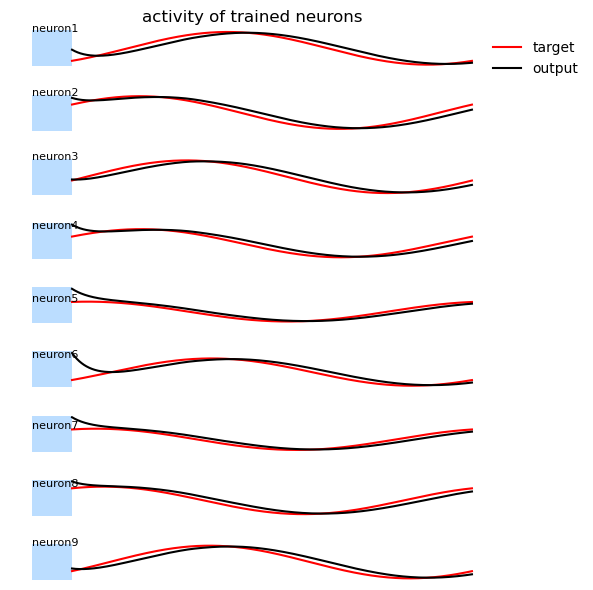

In [49]:
# Plot cell traces
tvec = collect((p.stim_off+1)/p.dt:p.learn_every/p.dt:p.train_time/p.dt)
ttarg = collect((p.stim_on+1)/p.dt:p.learn_every/p.dt:p.train_time/p.dt)

beg_train = Int(p.stim_off/p.dt)+1
stop_train = Int(p.train_time/p.dt)

figure(figsize=(6,6))
for ci = 1:9
    subplot(9,1,ci)
    axvspan(-(p.stim_off/p.dt-p.stim_on/p.dt), 0, color="dodgerblue", alpha=0.3, ec="None")
    #plot(tvec, r,ci], c="k", label = "trained")
    #plot(ttarg, vcat(I_ext[1][1:Int(p.learn_every/p.dt):end,ci], r_targ[1][:,ci]), c="r", lw=1, label="target")
    
    plot(r_targ[beg_train:stop_train, ci], color="red",label="target")
    plot(r[beg_train:stop_train, ci], color="black", label="output")
    annotate("neuron$(ci)", ((p.stim_on/p.dt)-1100,2.0), fontsize=8)
    
    if ci ==1
        title("activity of trained neurons")
        legend(frameon=false, bbox_to_anchor=(1.2, 1.05),loc="upper right")
    end
    axis("off")
end
tight_layout()
PyPlot.display_figs()

# Visualize change in trained weights

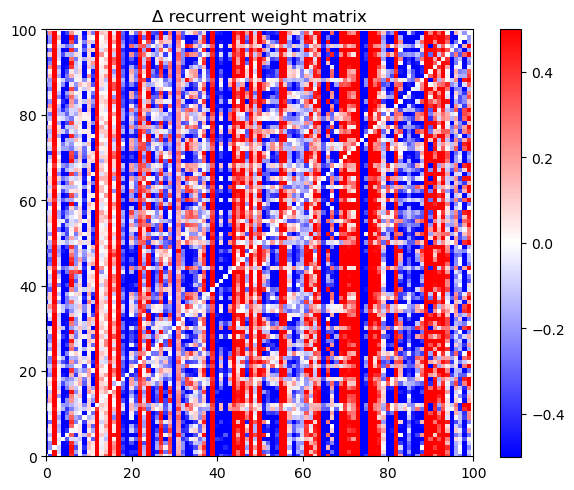

In [48]:
# Plot recurrent weight matrix
fig, ax = subplots(figsize=(6, 6))

delta_w_rec = w_rec .- w_rec_init

# Custom normalization centered at 0
norm = matplotlib.colors.CenteredNorm(vcenter=0, halfrange=0.5)
cax = ax.imshow(delta_w_rec, cmap="bwr", norm=norm)
colorbar(cax, shrink=0.75)

xlim(0,p.Ncells)
ylim(0,p.Ncells)
title("Δ recurrent weight matrix")

# Show plot
tight_layout()
show()